In [1]:
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import logging
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from sentence_transformers import SentenceTransformer
from bert_score import score


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\lbabu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\lbabu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\traitlets\config\application.py", line 1075, in launch

AttributeError: _ARRAY_API not found

C:\Users\lbabu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
# Basic similarity and distance functions
def cosine_sim(src, tgt):
    return cosine_similarity(src, tgt)

def manhattan_dist(src, tgt):
    return manhattan_distances(src, tgt)

def euclidean_dist(src, tgt):
    return euclidean_distances(src, tgt)

def angular_distance(src, tgt):
    cos_sim = cosine_similarity(src, tgt)
    np.fill_diagonal(cos_sim, 1)
    return 1 - (np.arccos(cos_sim) / math.pi)

def inner_product(src, tgt):
    return np.inner(src, tgt)

In [3]:
# Plot similarity matrix
def plot_similarity(sentences, similarity, method):
    max_sim = np.max(similarity)
    min_sim = np.min(similarity)

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)

    ax.matshow(
        similarity, vmin=min_sim, vmax=max_sim, interpolation="nearest", cmap="Greens"
    )

    for (i, j), z in np.ndenumerate(similarity):
        ax.text(j, i, "{:0.2f}".format(z), ha="center", va="center", fontsize=12)

    ax.tick_params(labelsize=15)
    ax.set_xticklabels([""] + sentences, rotation=45, ha="left")
    ax.set_yticklabels([""] + sentences)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_title(f"Sentence Similarity using {method.upper()}")

    plt.show()
    plt.close()


In [4]:
# Triangle-Sector similarity
def theta(src, tgt):
    cos_sim = cosine_sim(src, tgt)
    np.fill_diagonal(cos_sim, 1)
    return np.arccos(cos_sim) + np.radians(10)

def magnitude_difference(src, tgt):
    src_norm = np.linalg.norm(src, axis=1).reshape(-1, 1)
    tgt_norm = np.linalg.norm(tgt, axis=1)
    return np.abs(src_norm - tgt_norm)

def triangle_area_similarity(src, tgt, theta_):
    triangle_similarity = (np.linalg.norm(src, axis=1).reshape(-1, 1) * np.linalg.norm(tgt, axis=1) * np.sin(theta_)) / 2
    return triangle_similarity

def sector_area_similarity(src, tgt, theta_):
    distance_ = euclidean_dist(src, tgt)
    difference_ = magnitude_difference(src, tgt)
    return np.pi * ((distance_ + difference_) ** 2) * (theta_ / 360)

def triangle_sector_similarity(src, tgt):
    theta_ = theta(src, tgt)
    triangle_similarity = triangle_area_similarity(src, tgt, theta_)
    sector_similarity = sector_area_similarity(src, tgt, theta_)
    return triangle_similarity * sector_similarity

In [5]:
def bert_pairwise_cos_sim(sentences, idf=False):
    refs = [[sentence] * len(sentences) for sentence in sentences]
    refs = list(itertools.chain(*refs))
    hyps = sentences * len(sentences)

    p, _, _ = score(refs, hyps, lang="en", idf=idf)
    return p.reshape(len(sentences), -1).detach().numpy()

In [6]:
# Configuration for similarity calculation
class Config:
    def __init__(self, method="cosine", verbose=True):
        self.method = method
        self.verbose = verbose

In [15]:
class BERTCalculator:
    def __init__(self, config, sentences):
        self.sentences = sentences
        self.method = config.method
        self.verbose = config.verbose

    def calculate(self):
        methods = {
            "cosine": cosine_sim,
            "manhattan": manhattan_dist,
            "euclidean": euclidean_dist,
            "angular": angular_distance,
            "inner": inner_product,
            "ts-ss": triangle_sector_similarity,
        }

        if self.method not in methods:
            logging.error(f"The method '{self.method}' is not supported.")
            return False

        model = SentenceTransformer("bert-base-nli-mean-tokens")
        if self.verbose:
            logging.info("Embedding sentences...")

        embed_sentences = np.asarray(model.encode(self.sentences))
        method_func = methods[self.method]

        if self.verbose:
            logging.info("Calculating similarity...")

        similarity = method_func(embed_sentences, embed_sentences)
        self.plot_similarity(similarity)
        return similarity

    def plot_similarity(self, similarity):
        plot_similarity(self.sentences, similarity, self.method)

C:\Users\lbabu\AppData\Local\Temp\ipykernel_34372\1330939604.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + sentences, rotation=45, ha="left")
C:\Users\lbabu\AppData\Local\Temp\ipykernel_34372\1330939604.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + sentences)


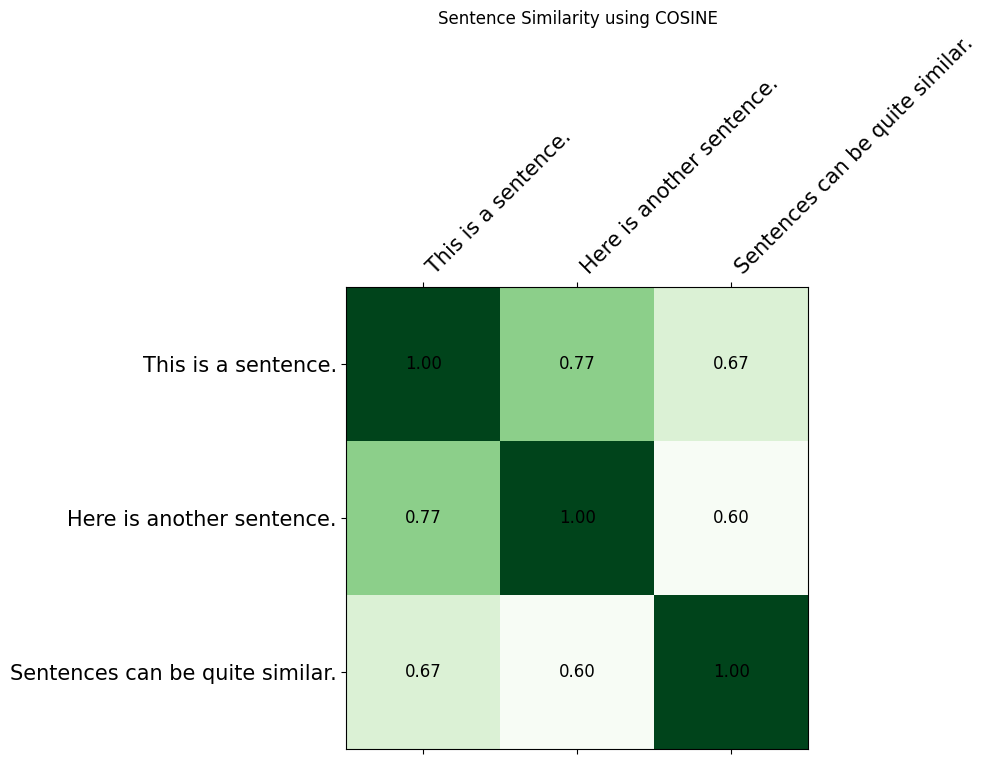

C:\Users\lbabu\AppData\Local\Temp\ipykernel_34372\1330939604.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + sentences, rotation=45, ha="left")
C:\Users\lbabu\AppData\Local\Temp\ipykernel_34372\1330939604.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + sentences)


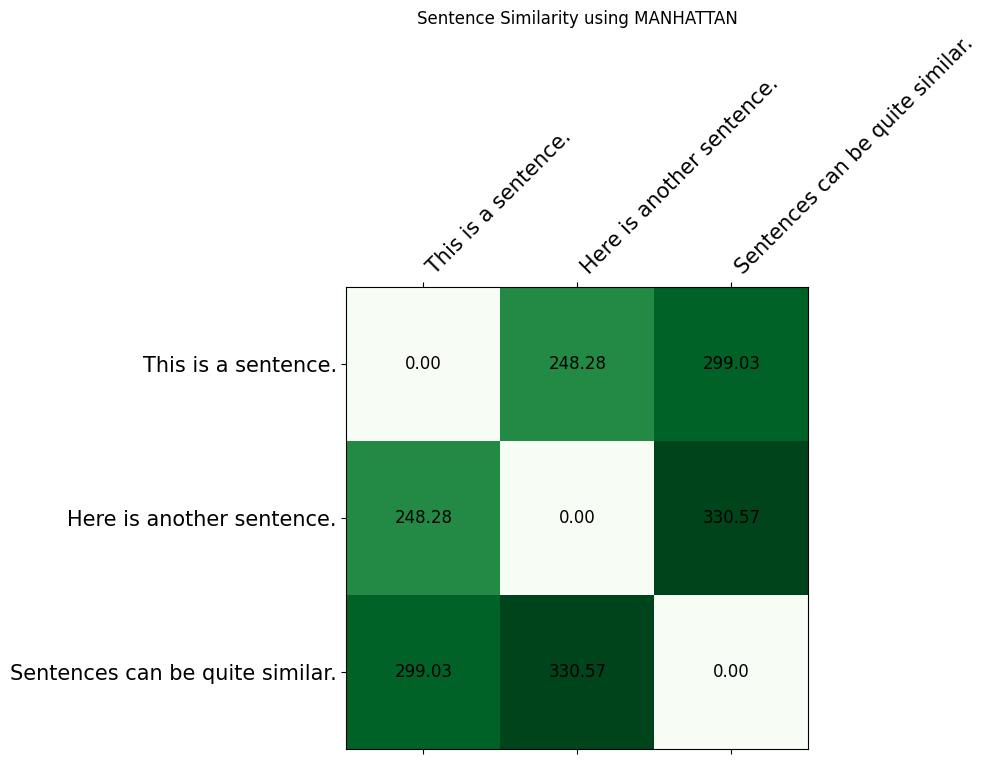

C:\Users\lbabu\AppData\Local\Temp\ipykernel_34372\1330939604.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + sentences, rotation=45, ha="left")
C:\Users\lbabu\AppData\Local\Temp\ipykernel_34372\1330939604.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + sentences)


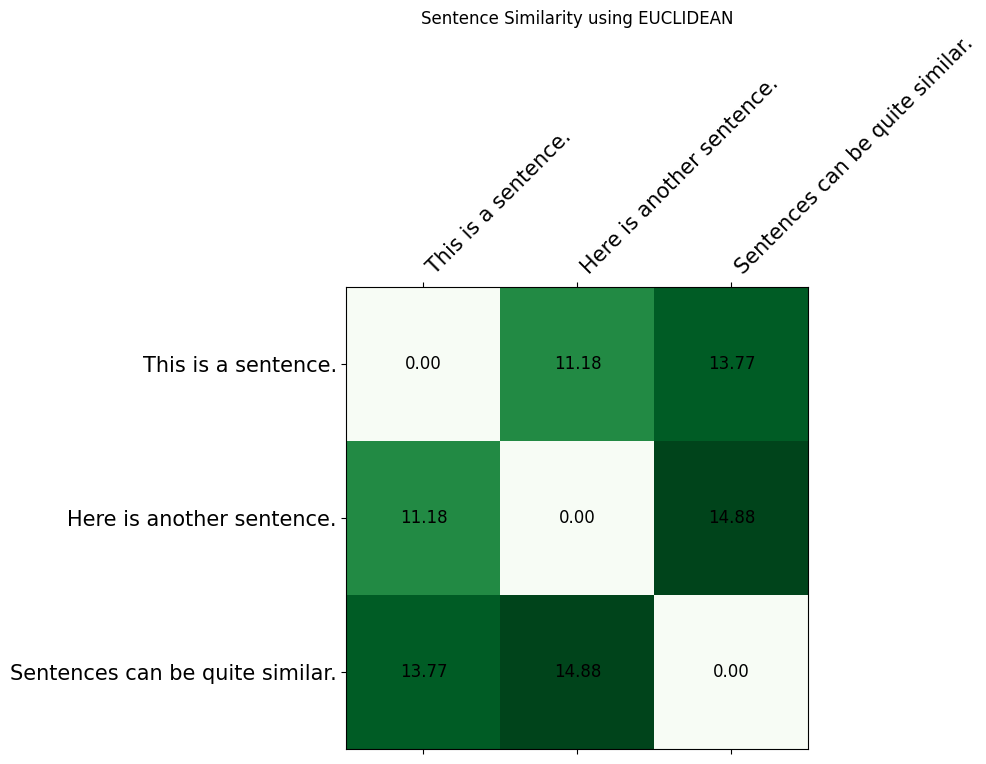

C:\Users\lbabu\AppData\Local\Temp\ipykernel_34372\1330939604.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + sentences, rotation=45, ha="left")
C:\Users\lbabu\AppData\Local\Temp\ipykernel_34372\1330939604.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + sentences)


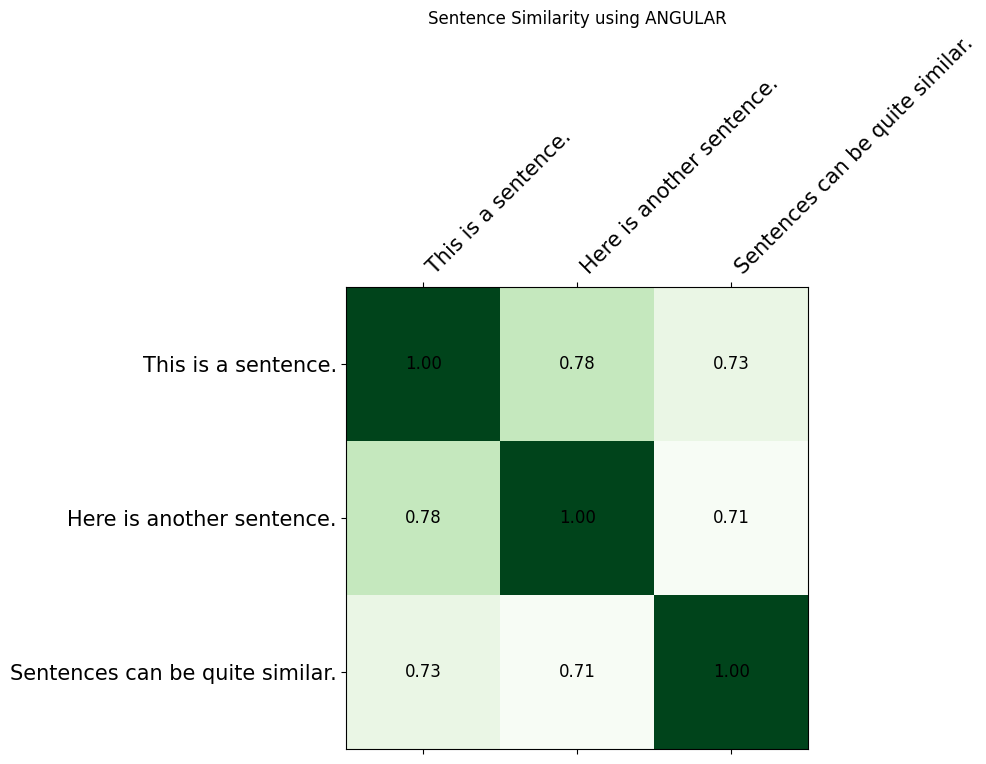

C:\Users\lbabu\AppData\Local\Temp\ipykernel_34372\1330939604.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + sentences, rotation=45, ha="left")
C:\Users\lbabu\AppData\Local\Temp\ipykernel_34372\1330939604.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + sentences)


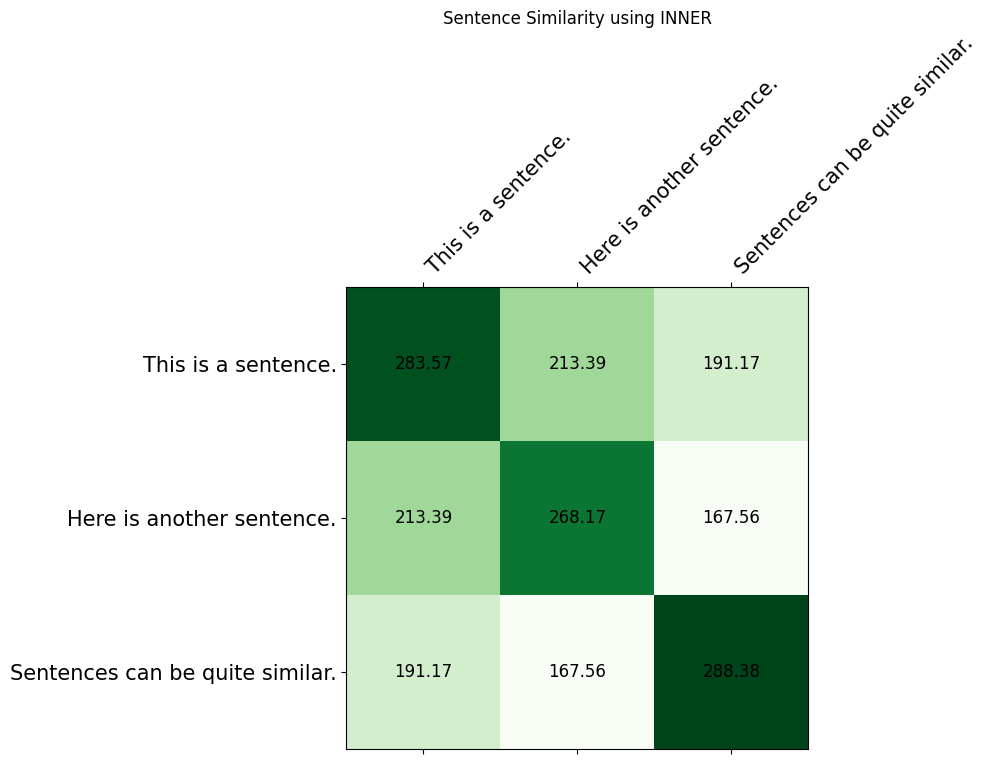

C:\Users\lbabu\AppData\Local\Temp\ipykernel_34372\1330939604.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + sentences, rotation=45, ha="left")
C:\Users\lbabu\AppData\Local\Temp\ipykernel_34372\1330939604.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + sentences)


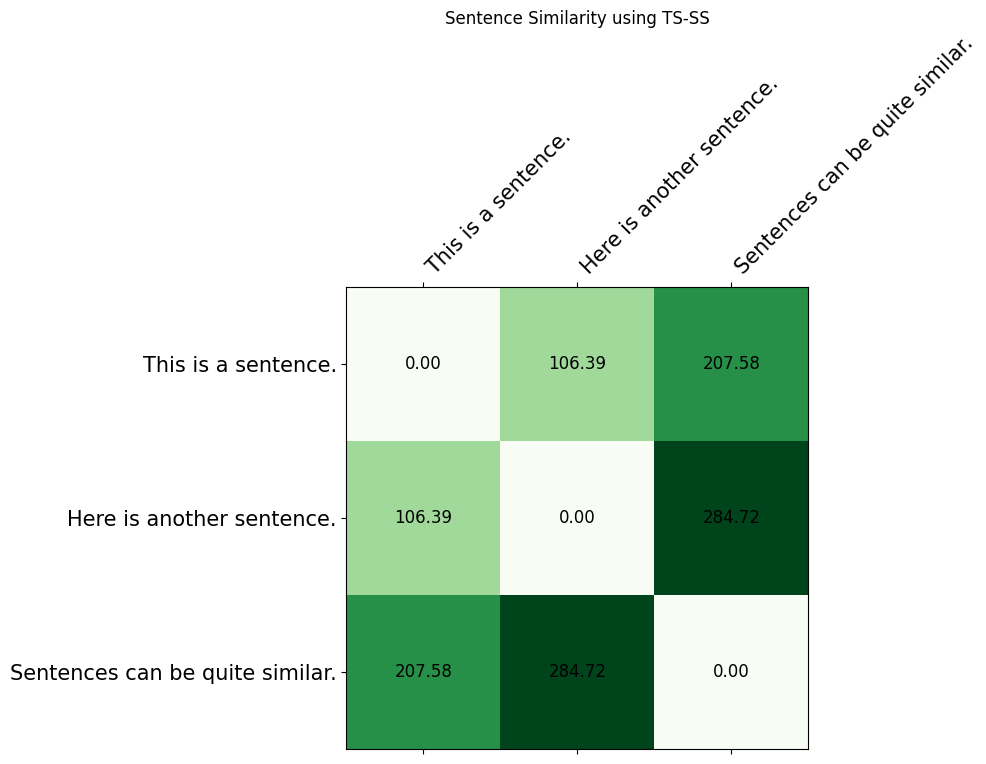

,S1-S1,S1-S2,S1-S3,S2-S1,S2-S2,S2-S3,S3-S1,S3-S2,S3-S3
cosine,1.000000,0.773823,0.668526,0.773823,1.000000,0.602546,0.668526,0.602546,1.000000
manhattan,0.000000,248.278488,299.034741,248.278488,0.000000,330.572664,299.034741,330.572664,0.000000
euclidean,0.000000,11.178425,13.769537,11.178425,0.000000,14.880262,13.769537,14.880262,0.000000
angular,1.000000,0.781658,0.733074,0.781658,1.000000,0.705847,0.733074,0.705847,1.000000
inner,283.571838,213.390839,191.174667,213.390839,268.166992,167.561249,191.174667,167.561249,288.377686
ts-ss,0.000000,106.393987,207.578152,106.393987,0.000000,284.722538,207.578152,284.722538,0.000000


In [16]:
import pandas as pd

# List of methods
methods = ["cosine", "manhattan", "euclidean", "angular", "inner", "ts-ss"]
results = {}

# Calculate similarity for each method and store full matrix
for m in methods:
    config = Config(method=m, verbose=True)
    calculator = BERTCalculator(config, sentences)
    similarity = calculator.calculate()
    
    if similarity is not None:
        # Flatten the similarity matrix to a 1D array for easier storage in the DataFrame
        similarity_flattened = similarity.flatten()
        results[m] = similarity_flattened  # Store the full matrix flattened as a row

# Convert results dictionary into a DataFrame, each row corresponds to a method's flattened similarity matrix
df_results = pd.DataFrame.from_dict(results, orient='index')

# Update column names to reflect sentence pairs (e.g., "S1-S1", "S1-S2", etc.)
num_sentences = len(sentences)
column_names = [f"S{i+1}-S{j+1}" for i in range(num_sentences) for j in range(num_sentences)]
df_results.columns = column_names

# Display the DataFrame
df_results
